<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full.csv


# Data Exploration

Check column types and if any null

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Check if any missing features

In [4]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

Check how balanced data is

No 36548
Yes 4640
Subscribed proportion 11.27%


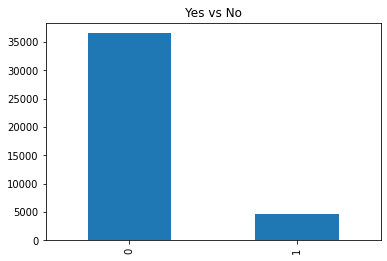

In [5]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no, yes = df.target.value_counts()
print(f'No {no}')
print(f'Yes {yes}')
print(f'Subscribed proportion {round(percentage(yes, yes + no), 2)}%')

df.target.value_counts().plot(kind="bar", title="Yes vs No");

## Data preprocessing

Check distribution of numerical data

target
0    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
1    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

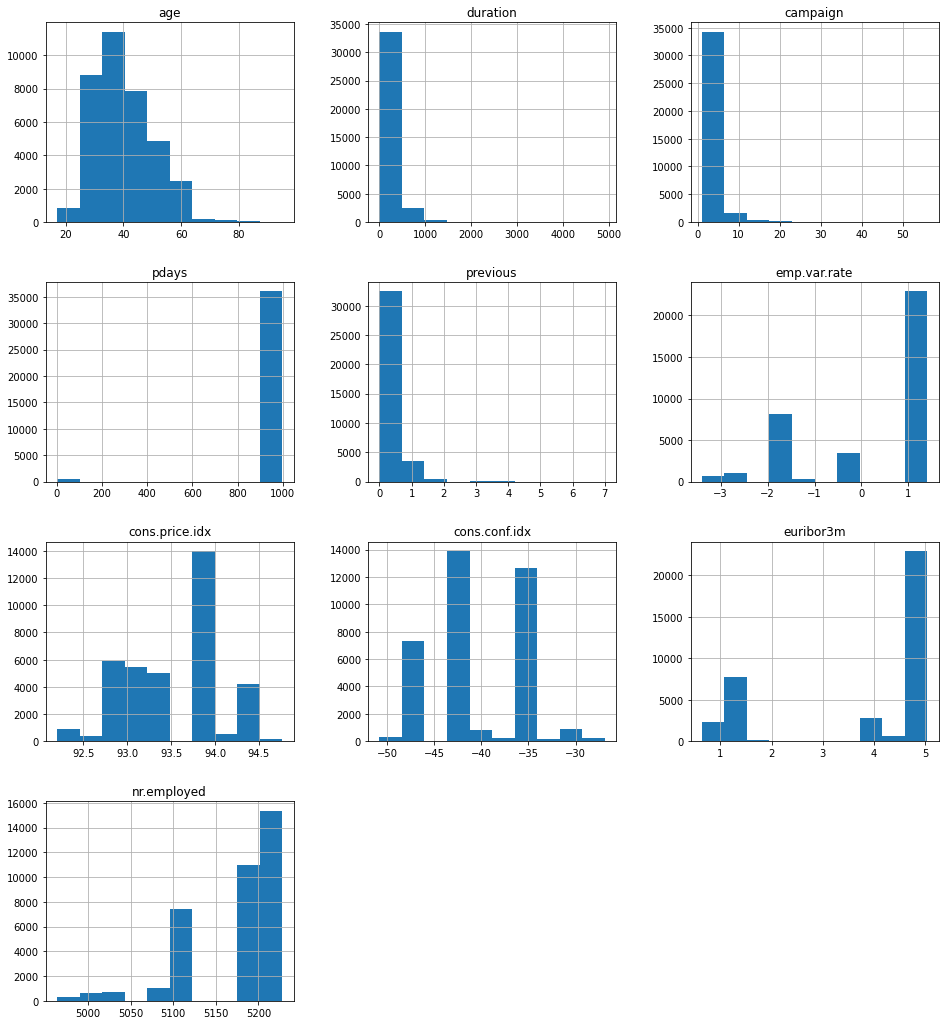

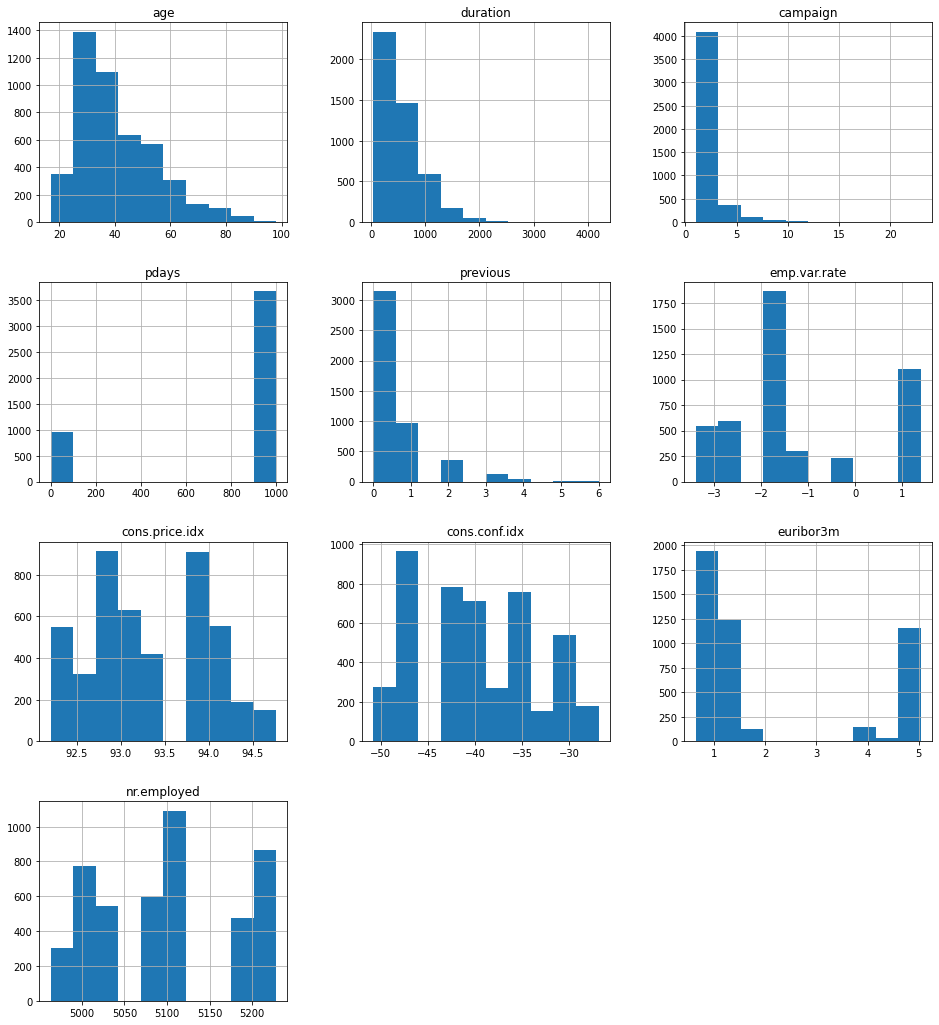

In [6]:
df.groupby('target').hist(figsize = (16,18))

Binning

In [7]:
processing_df = df

processing_df['pdays_binned'] = pd.cut(processing_df['pdays'], bins=2,labels=False,precision=1)
processing_df = processing_df.drop('pdays', axis=1)
processing_df['age_binned'] = pd.cut(processing_df['age'], bins=6,labels=False,precision=1)
processing_df = processing_df.drop('age', axis=1)

# Remove - duration as only for benchmark
processing_df = processing_df.drop('duration', 1)

Encode categorical features

In [8]:
categorical_columns = ["job","housing", "marital","education","default","loan","contact","month","day_of_week","poutcome"]

# Using one-hot encoding as no order so don't confuse model
for column in categorical_columns:
    tempdf = pd.get_dummies(processing_df[column], prefix=column)
    processing_df = pd.merge(
        left=processing_df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    processing_df = processing_df.drop(columns=column)

Check correlation of features

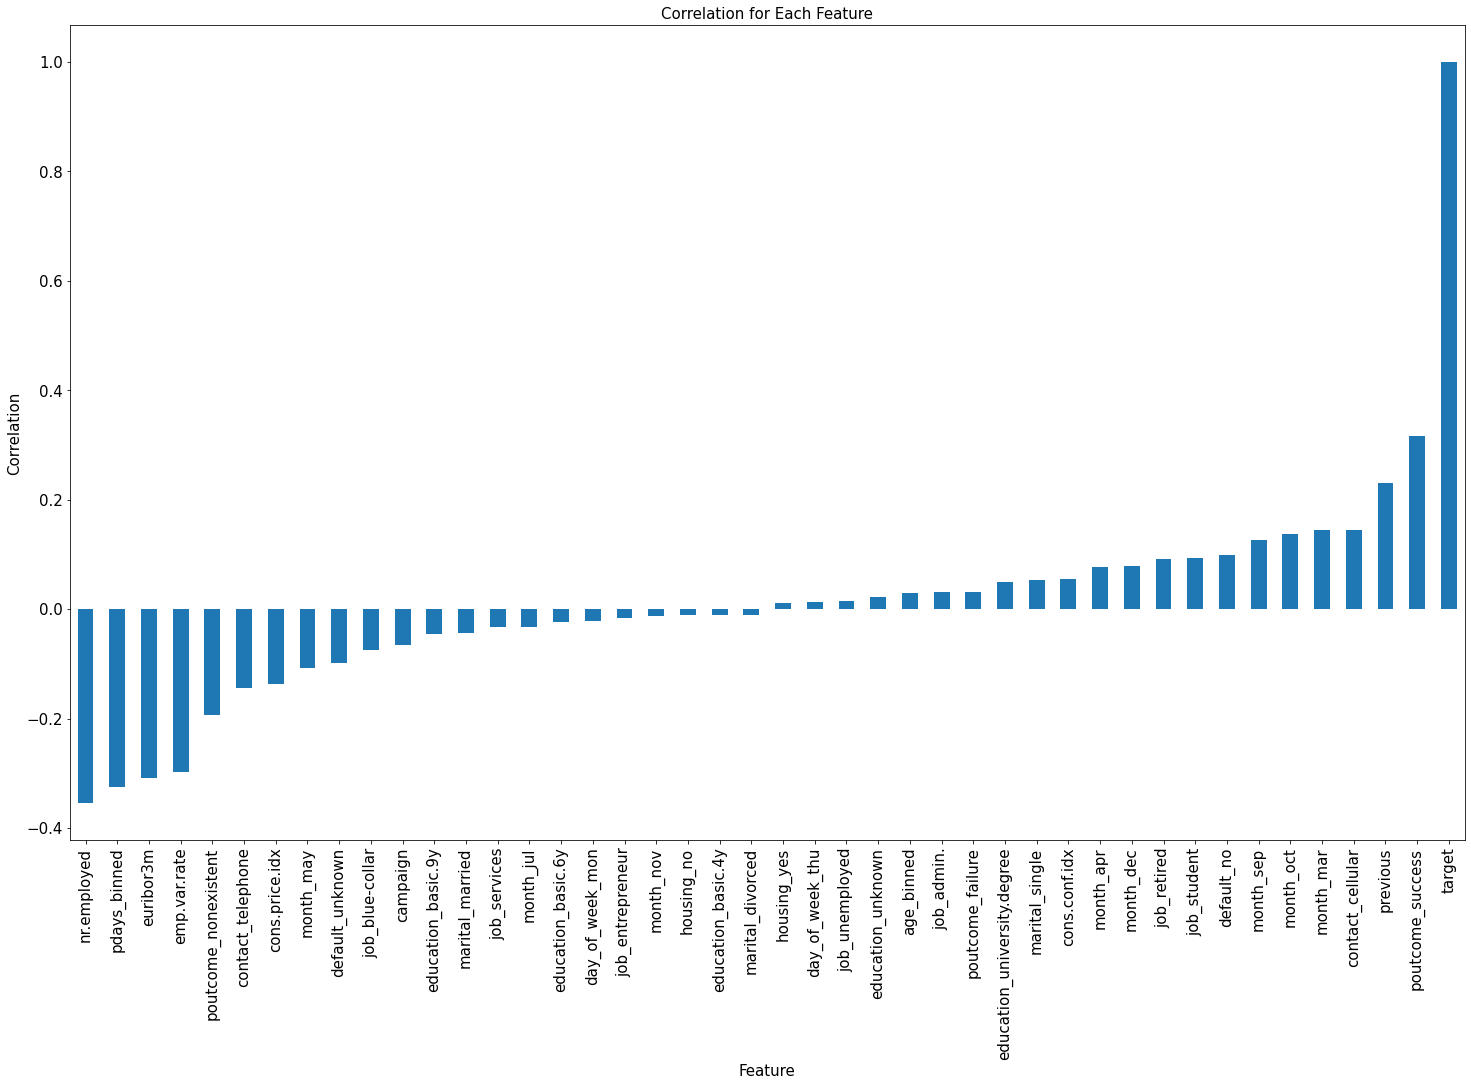

In [9]:
# # Create correlation matrix
std_features_keep = processing_df
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.01

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

# Metrics

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [11]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [12]:
from sklearn.metrics import f1_score

from prettytable import PrettyTable

def print_metrics(name_model,model, evaluation_results, predictions):
  labels = model.metrics_names
  labels.insert(0, "Name of Model")
  results = evaluation_results  
  results = [ '%.2f' % elem for elem in results ]
  results.insert(0, name_model)
  t = PrettyTable(labels)
  t.add_row(results)
  print(t)

In [13]:
def visualise_training_history_accuracy(ax, history, title):
  # Get training and test accuracy histories
  training_accuracy = history.history["accuracy"]
  test_accuracy = history.history["val_accuracy"]
  epoch_count = range(1, len(training_accuracy) + 1)
  ax.plot(epoch_count, training_accuracy, "r--")
  ax.plot(epoch_count, test_accuracy, "b-")
  # Visualize accuracy history
  ax.legend(["Training Accuracy", "Test Accuracy"])
  ax.title.set_text(title)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy Score")

In [14]:
def visualise_training_history_loss(ax, history, title):
  # Get training and test loss histories
  training_loss = history.history["loss"]
  test_loss = history.history["val_loss"]
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  # Visualize loss history
  ax.plot(epoch_count, training_loss, "r--")
  ax.plot(epoch_count, test_loss, "b-")
  ax.legend(["Training Loss", "Test Loss"])
  ax.title.set_text(title)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")

## Neural Network

In [15]:
BATCH_SIZE = 2048

import keras
from keras import backend as K
import tensorflow as tf
from keras import layers

def build_model(number_inputs,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  network = keras.Sequential()
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu",input_dim=number_inputs))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=480, activation="relu"))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid",bias_initializer=output_bias))

  network.compile(
    optimizer="rmsprop",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return network

# Split Training and Test Data

In [16]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop("target", axis=1)
y = df['target']

labels = X.columns.values
number_inputs = len(X.columns)

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 1.0


# Plain Model

In [17]:
plain_model = build_model(number_inputs)

history_plain = plain_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_test, y_test), 
    shuffle=True)

Epoch 1/10
15/15 [==============================] - 6s 95ms/step - loss: 0.5947 - tp: 584.0000 - fp: 6195.0000 - tn: 19385.0000 - fn: 2667.0000 - accuracy: 0.6926 - precision: 0.0861 - recall: 0.1796 - auc: 0.4142 - prc: 0.0970 - val_loss: 0.3968 - val_tp: 1.0000 - val_fp: 17.0000 - val_tn: 10951.0000 - val_fn: 1388.0000 - val_accuracy: 0.8863 - val_precision: 0.0556 - val_recall: 7.1994e-04 - val_auc: 0.4900 - val_prc: 0.1069
Epoch 2/10
15/15 [==============================] - 0s 13ms/step - loss: 0.3595 - tp: 2.0000 - fp: 12.0000 - tn: 25568.0000 - fn: 3249.0000 - accuracy: 0.8869 - precision: 0.1429 - recall: 6.1520e-04 - auc: 0.5976 - prc: 0.1506 - val_loss: 0.3289 - val_tp: 29.0000 - val_fp: 24.0000 - val_tn: 10944.0000 - val_fn: 1360.0000 - val_accuracy: 0.8880 - val_precision: 0.5472 - val_recall: 0.0209 - val_auc: 0.6948 - val_prc: 0.2599
Epoch 3/10
15/15 [==============================] - 0s 17ms/step - loss: 0.3170 - tp: 216.0000 - fp: 139.0000 - tn: 25441.0000 - fn: 3035.000

+---------------+------+--------+-------+----------+---------+----------+-----------+--------+------+------+
| Name of Model | loss |   tp   |   fp  |    tn    |    fn   | accuracy | precision | recall | auc  | prc  |
+---------------+------+--------+-------+----------+---------+----------+-----------+--------+------+------+
|  Plain Model  | 0.29 | 198.00 | 61.00 | 10907.00 | 1191.00 |   0.90   |    0.76   |  0.14  | 0.77 | 0.43 |
+---------------+------+--------+-------+----------+---------+----------+-----------+--------+------+------+


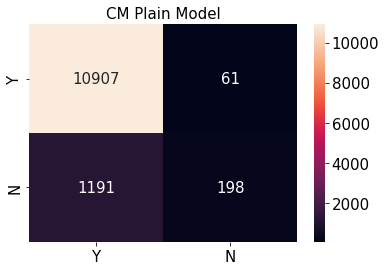

In [18]:
evaluation_results = plain_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = plain_model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics("Plain Model",plain_model, evaluation_results, y_pred)

fig, ax = plt.subplots()
plot_cm(ax,y_test, y_pred, "CM Plain Model")

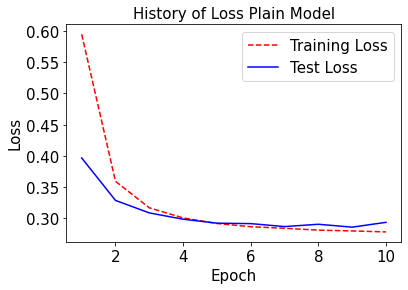

In [19]:
fig, ax = plt.subplots()
visualise_training_history_loss(ax, history_plain,"History of Loss Plain Model")

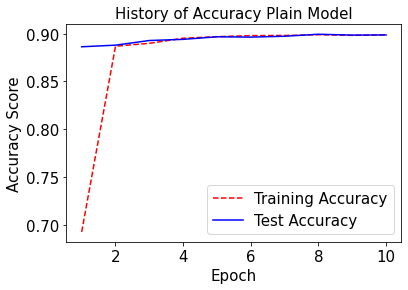

In [20]:
fig, ax = plt.subplots()
visualise_training_history_accuracy(ax,history_plain,"History of Accuracy Plain Model")

# Weighted model

In [21]:
no_count, yes_count = np.bincount(df.target)
total_count = len(df.target)

weight_no = ((1 / no_count) * (total_count) / 2.0 )
weight_yes = (((1 / yes_count) * (total_count) / 2.0 )) 
print("No:  " + str(weight_no))
print("Yes:  " + str(weight_yes))
class_weights = {0: weight_no, 1: weight_yes}

No:  0.5634781656999015
Yes:  4.438362068965517


In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

initial_bias = np.log([yes/no])
model_weighted = build_model(number_inputs, initial_bias)

callbacks = [EarlyStopping(monitor="val_loss", patience=3),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/100
15/15 [==============================] - 7s 177ms/step - loss: 0.7386 - tp: 1927.0000 - fp: 5454.0000 - tn: 31094.0000 - fn: 2713.0000 - accuracy: 0.8017 - precision: 0.2611 - recall: 0.4153 - auc: 0.6468 - prc: 0.2898 - val_loss: 0.6242 - val_tp: 821.0000 - val_fp: 2729.0000 - val_tn: 8239.0000 - val_fn: 568.0000 - val_accuracy: 0.7332 - val_precision: 0.2313 - val_recall: 0.5911 - val_auc: 0.7197 - val_prc: 0.3296
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 0.5872 - tp: 1886.0000 - fp: 5235.0000 - tn: 20345.0000 - fn: 1365.0000 - accuracy: 0.7711 - precision: 0.2649 - recall: 0.5801 - auc: 0.7484 - prc: 0.3538 - val_loss: 0.5619 - val_tp: 894.0000 - val_fp: 2544.0000 - val_tn: 8424.0000 - val_fn: 495.0000 - val_accuracy: 0.7541 - val_precision: 0.2600 - val_recall: 0.6436 - val_auc: 0.7608 - val_prc: 0.3687
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 0.5650 - tp: 2103.0000 - fp: 5330.0000 - tn: 20250.0000 - fn: 1

Evaluation

+------------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+
|  Name of Model   | loss |   tp   |    fp   |    tn   |   fn   | accuracy | precision | recall | auc  | prc  |
+------------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+
| Model Reweighted | 0.53 | 873.00 | 1833.00 | 9135.00 | 516.00 |   0.81   |    0.32   |  0.63  | 0.78 | 0.43 |
+------------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+


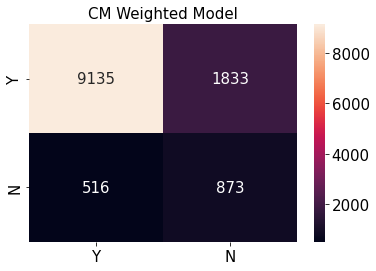

In [25]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics("Model Reweighted",model_weighted, evaluation_results, y_pred)

fig, ax = plt.subplots()
plot_cm(ax,y_test, y_pred, "CM Weighted Model")

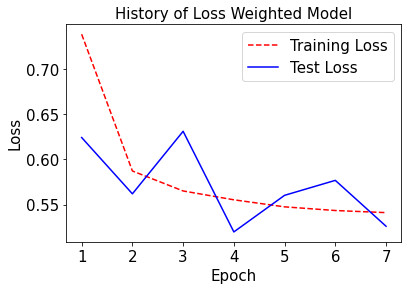

In [26]:
fig, ax = plt.subplots()
visualise_training_history_loss(ax,history_weighted,"History of Loss Weighted Model")

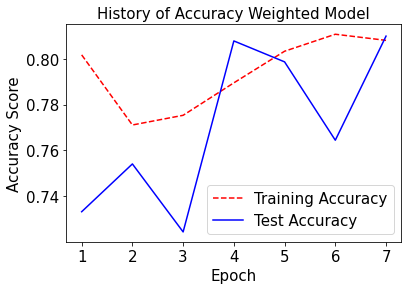

In [27]:
fig, ax = plt.subplots()
visualise_training_history_accuracy(ax,history_weighted,"History of Accuracy Weighted Model")

# Resampling

In [28]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=1.0);
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

No Resampled 25580
Yes Resampled 25580
Subscribe Resampled proportion 50.0%


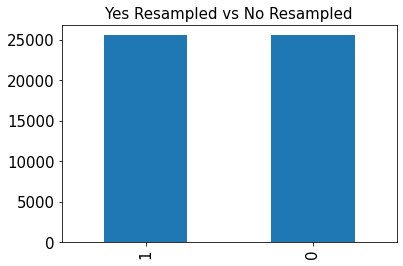

In [29]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

no_resampled, yes_resampled = y_train_resampled.value_counts()
print(f'No Resampled {no_resampled}')
print(f'Yes Resampled {yes_resampled}')
print(f'Subscribe Resampled proportion {round(percentage(yes_resampled,yes_resampled + no_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="Yes Resampled vs No Resampled");

In [30]:
model_resampled = build_model(number_inputs)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="val_loss", patience=3),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_resampled = model_resampled.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
)

Epoch 1/100
25/25 [==============================] - 5s 50ms/step - loss: 0.5742 - tp: 19547.0000 - fp: 10147.0000 - tn: 26401.0000 - fn: 7422.0000 - accuracy: 0.7234 - precision: 0.6583 - recall: 0.7248 - auc: 0.7890 - prc: 0.7366 - val_loss: 0.5546 - val_tp: 941.0000 - val_fp: 2430.0000 - val_tn: 8538.0000 - val_fn: 448.0000 - val_accuracy: 0.7671 - val_precision: 0.2791 - val_recall: 0.6775 - val_auc: 0.7746 - val_prc: 0.4103
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 0.5342 - tp: 17373.0000 - fp: 4911.0000 - tn: 20669.0000 - fn: 8207.0000 - accuracy: 0.7436 - precision: 0.7796 - recall: 0.6792 - auc: 0.8009 - prc: 0.8157 - val_loss: 0.5172 - val_tp: 869.0000 - val_fp: 1834.0000 - val_tn: 9134.0000 - val_fn: 520.0000 - val_accuracy: 0.8095 - val_precision: 0.3215 - val_recall: 0.6256 - val_auc: 0.7788 - val_prc: 0.4213
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.5245 - tp: 17003.0000 - fp: 4231.0000 - tn: 21349.0000 - fn

+-----------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+
|  Name of Model  | loss |   tp   |    fp   |    tn   |   fn   | accuracy | precision | recall | auc  | prc  |
+-----------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+
| Model Resampled | 0.52 | 865.00 | 1706.00 | 9262.00 | 524.00 |   0.82   |    0.34   |  0.62  | 0.78 | 0.44 |
+-----------------+------+--------+---------+---------+--------+----------+-----------+--------+------+------+


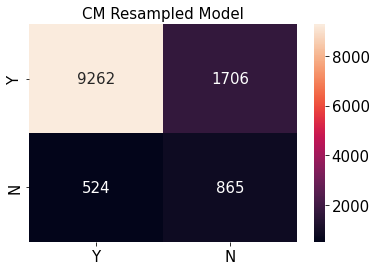

In [31]:
evaluation_results = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics("Model Resampled",model_resampled, evaluation_results, y_pred)

fig, ax = plt.subplots()
plot_cm(ax,y_test, y_pred, "CM Resampled Model")

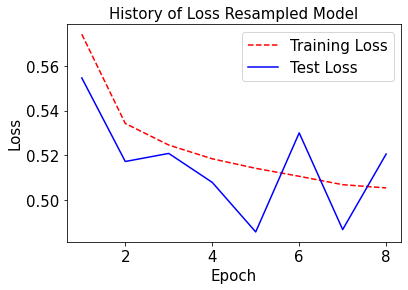

In [32]:
fig, ax = plt.subplots()
visualise_training_history_loss(ax,history_resampled,"History of Loss Resampled Model")

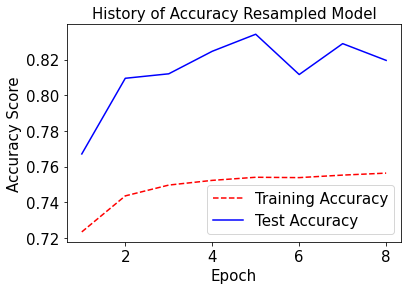

In [33]:
fig, ax = plt.subplots()
visualise_training_history_accuracy(ax,history_resampled,"History of Accuracy Resampled Model")

# Evaluation

History of Loss Comparison

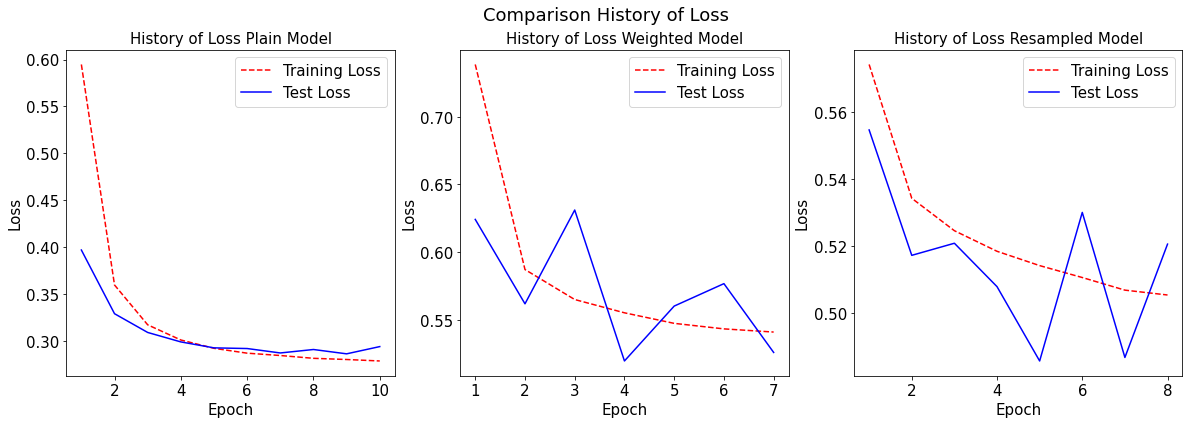

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
fig.suptitle('Comparison History of Loss')
visualise_training_history_loss(ax1, history_plain,"History of Loss Plain Model")
visualise_training_history_loss(ax2, history_weighted,"History of Loss Weighted Model")
visualise_training_history_loss(ax3, history_resampled,"History of Loss Resampled Model")

History of Accuracy Comparison

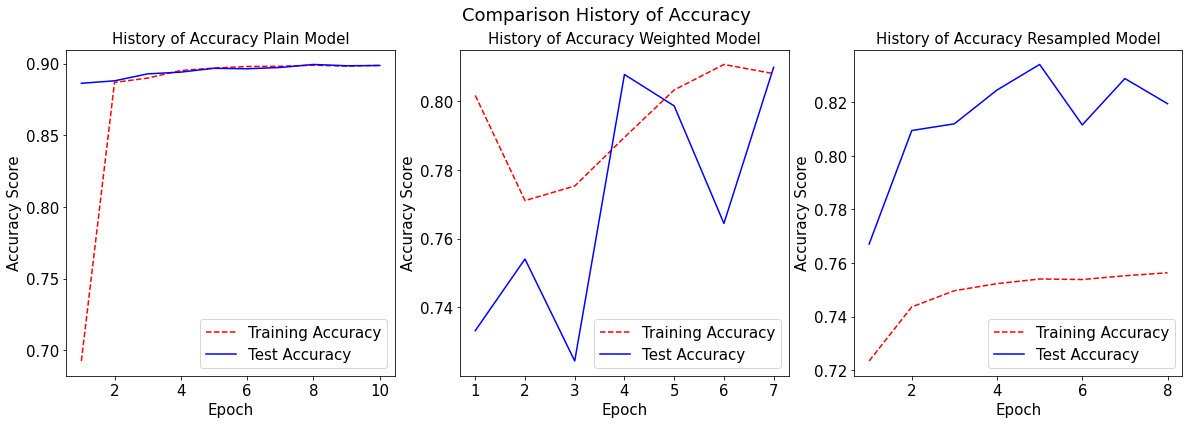

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
fig.suptitle('Comparison History of Accuracy')
visualise_training_history_accuracy(ax1, history_plain,"History of Accuracy Plain Model")
visualise_training_history_accuracy(ax2, history_weighted,"History of Accuracy Weighted Model")
visualise_training_history_accuracy(ax3, history_resampled,"History of Accuracy Resampled Model")

Correlation Matrix Comparison

+-----------------+------+--------+---------+----------+---------+----------+-----------+--------+------+------+
|  Name of Model  | loss |   tp   |    fp   |    tn    |    fn   | accuracy | precision | recall | auc  | prc  |
+-----------------+------+--------+---------+----------+---------+----------+-----------+--------+------+------+
|   Plain Model   | 0.29 | 198.00 |  61.00  | 10907.00 | 1191.00 |   0.90   |    0.76   |  0.14  | 0.77 | 0.43 |
|  Weighted Model | 0.53 | 873.00 | 1833.00 | 9135.00  |  516.00 |   0.81   |    0.32   |  0.63  | 0.78 | 0.43 |
| Resampled Model | 0.52 | 865.00 | 1706.00 | 9262.00  |  524.00 |   0.82   |    0.34   |  0.62  | 0.78 | 0.44 |
+-----------------+------+--------+---------+----------+---------+----------+-----------+--------+------+------+


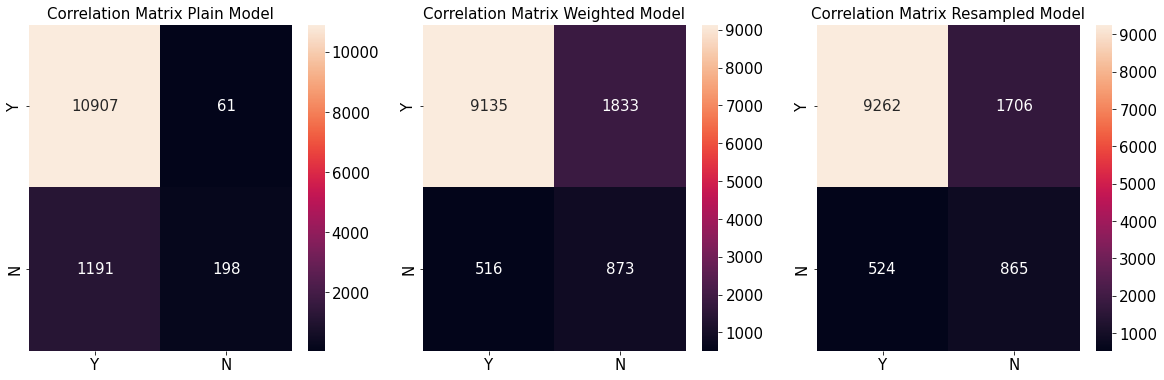

In [36]:
labels = plain_model.metrics_names
labels.insert(0, "Name of Model")
t = PrettyTable(labels)

evaluation_results_plain_model = plain_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred_plain_model = plain_model.predict(X_test, batch_size=BATCH_SIZE)
results_plain_model = [ '%.2f' % elem for elem in evaluation_results_plain_model]
results_plain_model.insert(0, "Plain Model")
t.add_row(results_plain_model)

evaluation_results_model_weighted = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred_model_weighted = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
results_model_weighted  = [ '%.2f' % elem for elem in evaluation_results_model_weighted]
results_model_weighted.insert(0, "Weighted Model")
t.add_row(results_model_weighted)

evaluation_results_resampled_model = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred_model_resampled = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
results_model_resampled  = [ '%.2f' % elem for elem in evaluation_results_resampled_model]
results_model_resampled.insert(0, "Resampled Model")
t.add_row(results_model_resampled)

print(t)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
plot_cm(ax1,y_test, y_pred_plain_model,"Correlation Matrix Plain Model")
plot_cm(ax2,y_test, y_pred_model_weighted,"Correlation Matrix Weighted Model")
plot_cm(ax3,y_test, y_pred_model_resampled,"Correlation Matrix Resampled Model")

# Hyperparamter tuning (optional as takes time to run)

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 5.1 MB/s 


In [ ]:
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras # importing keras

def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  network = keras.Sequential()
  network.add(layers.Dense(units=hp_units, activation="relu",input_dim=number_inputs))
  network.add(layers.Dense(units=16, activation="relu"))
  network.add(layers.Dense(units=1, activation="sigmoid"))

  network.compile(
    optimizer="rmsprop",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )
  return network

tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective="val_loss", # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir3', # directory to save logs 
project_name='khyperband')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# Perform hypertuning
tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_test, y_test))

Trial 21 Complete [00h 00m 31s]
val_loss: 0.5018502473831177

Best val_loss So Far: 0.5018502473831177
Total elapsed time: 00h 08m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
print(tuner.results_summary())
# Build the model with the optimal hyperparameters and train it on the data for N epochs

Results summary
Results in dir3/khyperband
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 160
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5018502473831177
Trial summary
Hyperparameters:
units: 224
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5039137601852417
Trial summary
Hyperparameters:
units: 192
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 29e7088f7f5aa00c158c0eb5b92b3d06
Score: 0.5051102638244629
Trial summary
Hyperparameters:
units: 32
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5052986145019531
Trial summary
Hyperparameters:
units: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0f292e26782ffddd3b2ab026ae490730
Score: 0.5102987885475159
Trial summary
Hyperparameters:
units: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2


# Architecture

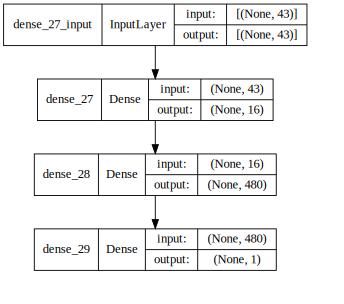

In [ ]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(plain_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))